This script would like to build an experimental Ripple Carry Adder composed by radix-10 Full Adders,

with the aim of overcoming the CPU register HW limitations,
and transforming computing process in RAM physical limitations with as experimental SW solution.

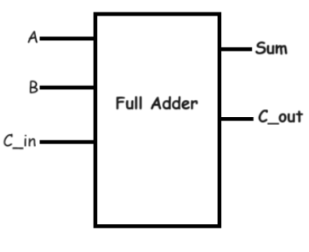

A Full Adder cell takes three inputs: previous computation carry (Cin), A and B digits, and gives in output the unit digit Sum and an output Carry (Cout).

In general this device is Silicon-based and it performs operations in radix-2 (or binary computing as well).

Then, the Ripple Carry Adder is composed by a cascade of FullAdders:

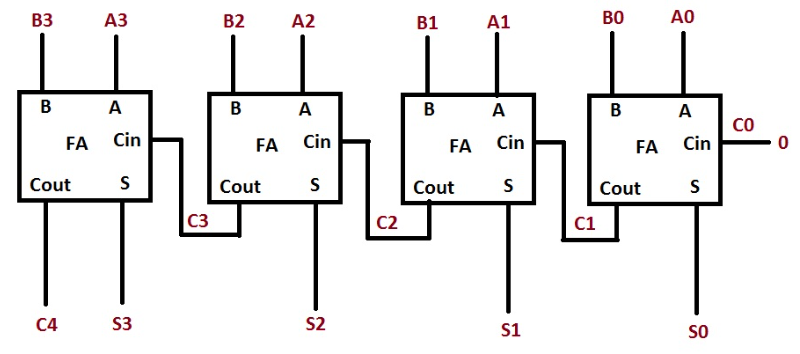

Import Tensorflow and useful libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer

import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os

When Dealing with three inputs and considering two of them of 10 digits (0 to 9) and carry which can only be 0 or 1, 

there are 10\*10\*2 = 200 possible permutations.

The following Classes Generator and DataCreator, compute exactly these permutations in the following format:

[A_ith, B_ith, Cin_ith, Sum_ith, Cout_ith]

Possible improvements: Use recursion instead of three nested loops

In [3]:
#Data creation
class Generator:

    def __init__(self):
        self.upper = 10
        self.combo_list = []
        self.__execute_computing()

    def __execute_computing(self):
        for a in range(0,self.upper):
            for b in range(0,self.upper):
                for c_in in range(0,2):
                    c_out = 1 if a+b+c_in>=10 else 0
                    y = a+b+c_in if a+b+c_in<10 else a+b+c_in-10
                    self.combo_list.append([a, b, c_in, y, c_out])

In [4]:
class DataCreator:
    def __init__(self):
        obj_gen = Generator()
        self.array_gen = np.array(obj_gen.combo_list)
        print(self.array_gen.shape)
    def __call__(self):
      return self.array_gen[:,:3], self.array_gen[:,3].reshape((-1,1)), self.array_gen[:,4].reshape((-1,1))


X_train, S_train, C_train = DataCreator()()

(200, 5)


Check if Splitting reshaped as wanted

In [5]:
print(f"X set shape: {X_train.shape}")
print(f"Y set shape: {S_train.shape}")
print(f"C set shape: {C_train.shape}")

X set shape: (200, 3)
Y set shape: (200, 1)
C set shape: (200, 1)


The following three lines are used for user friendly purposes.

Pick K=5 random indexes and evaluate if permutations are correct.

As anyone could see, the first row assumed 8 + 6 as digit sum with an Input Carry equal to 1, 

then it gives as output Sum=5 and 1 as output carry. Correct!!

even the following four lines are also correct.

In [6]:
#Verify that random sums are correct
for _ in range(5):
  index = random.randint(0,X_train.shape[0])
  print(f"These numbers summed: {X_train[index]} give S: {S_train[index]} and Cout: {C_train[index]}\n")

These numbers summed: [8 6 1] give S: [5] and Cout: [1]

These numbers summed: [4 5 0] give S: [9] and Cout: [0]

These numbers summed: [3 1 1] give S: [5] and Cout: [0]

These numbers summed: [8 8 0] give S: [6] and Cout: [1]

These numbers summed: [6 8 0] give S: [4] and Cout: [1]



Now FullAdder structure is going to be mimed by a Branch Newtork. The DNN structure is the following

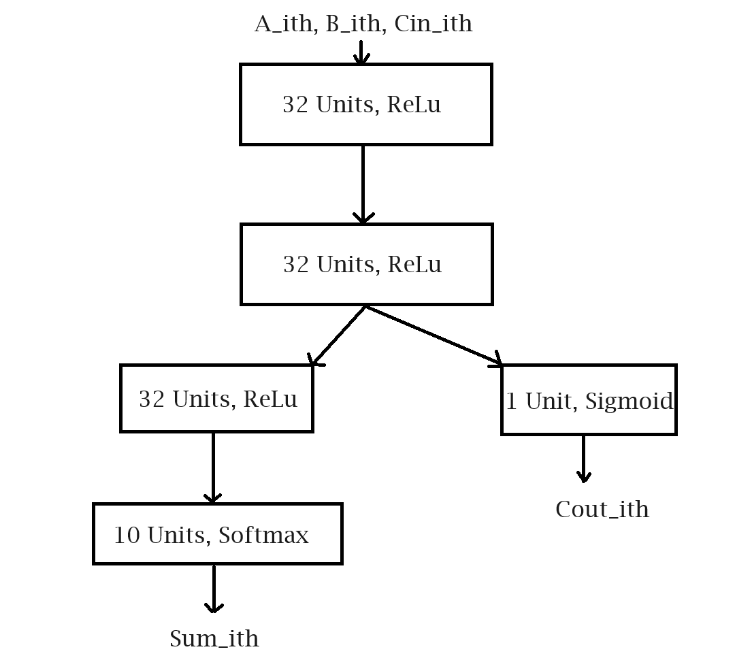


In [7]:
#model creation with functional API
class BaseLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense0 = tf.keras.layers.Dense(32, activation='relu',
                                            input_shape=(None,3),
                                            kernel_regularizer=tf.keras.regularizers.L2(0.01),
                                            kernel_initializer='he_normal')
        self.dense1 = tf.keras.layers.Dense(32, activation='relu',
                                            kernel_regularizer=tf.keras.regularizers.L2(0.01),
                                            kernel_initializer='he_normal')
    def call(self, inputs):
        x0 = inputs
        x1 = self.dense0(x0)
        return self.dense1(x1)

class OutputLayers(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.cout = tf.keras.layers.Dense(1, activation='sigmoid',
                                          kernel_initializer='he_normal')
        self.sum0 = tf.keras.layers.Dense(32, activation='relu',
                                          kernel_initializer='he_normal')
        self.sum1 = tf.keras.layers.Dense(10, activation=None,
                                          kernel_initializer='he_normal')
    def call(self, inputs):
        x0 = inputs
        x1 = self.sum0(x0)
        return self.cout(x0), self.sum1(x1)

In [8]:
class Branch_Net(tf.keras.Model):
    def __init__(self):
        super(Branch_Net, self).__init__()
        self.base = BaseLayer()
        self.out = OutputLayers()

    def call(self, inputs):
        x0 = inputs
        x1 = self.base(x0)
        self.out2 = self.out(x1)
        return self.out2

Callbacks is used to stop when Completly fitting is reached. 

Be Carefull, The aim is to fit completely all the permutations, because we know already that there are not anymore symbols in radix-10 computing.

We don't need to predict anything, remember the FullAdder is used as certain computation component. No forecasting is needed.

In [20]:
class EarlyStop(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('output_1_accuracy') is not None and \
        logs.get('output_1_accuracy') == 1.0 and \
        logs.get('output_2_accuracy') is not None and \
        logs.get('output_2_accuracy') == 1.0:
            print("\nReached wanted accuracy so cancelling training!")
            self.model.stop_training = True
early_stop_cb = EarlyStop()

In [21]:
#Assembling the model
model = Branch_Net()

Four iterations with different learning rate and epoch number are done.

Future Improvement: learning rate scheduler implementation

In [22]:
epochs=[2000, 300, 300, 300]
learning_rate = [2e-3, 8e-4, 2e-4, 5e-5]
history = []
for epoch, lr in zip(epochs, learning_rate):
    model.compile(
            loss={'output_1': 'binary_crossentropy',
                  'output_2': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            metrics={'output_1':'accuracy',
                     'output_2': 'accuracy'})

    history.append(model.fit(
          X_train, (C_train, S_train),
          epochs=epoch,
          batch_size=4,
          verbose=1,
          callbacks=[early_stop_cb]))


Epoch 1/2000
50/50 [==============================] - 1s 3ms/step - loss: 5.9325 - output_1_loss: 1.0001 - output_2_loss: 3.7878 - output_1_accuracy: 0.5700 - output_2_accuracy: 0.0700
Epoch 2/2000
50/50 [==============================] - 0s 3ms/step - loss: 4.1543 - output_1_loss: 0.5534 - output_2_loss: 2.6015 - output_1_accuracy: 0.6850 - output_2_accuracy: 0.0650
Epoch 3/2000
50/50 [==============================] - 0s 2ms/step - loss: 3.8810 - output_1_loss: 0.5121 - output_2_loss: 2.4645 - output_1_accuracy: 0.7550 - output_2_accuracy: 0.1050
Epoch 4/2000
50/50 [==============================] - 0s 3ms/step - loss: 3.8287 - output_1_loss: 0.4979 - output_2_loss: 2.4929 - output_1_accuracy: 0.7550 - output_2_accuracy: 0.0750
Epoch 5/2000
50/50 [==============================] - 0s 3ms/step - loss: 3.7230 - output_1_loss: 0.4887 - output_2_loss: 2.4467 - output_1_accuracy: 0.7700 - output_2_accuracy: 0.0950
Epoch 6/2000
50/50 [==============================] - 0s 3ms/step - loss: 3

Following Charts are used for sanity check about training process

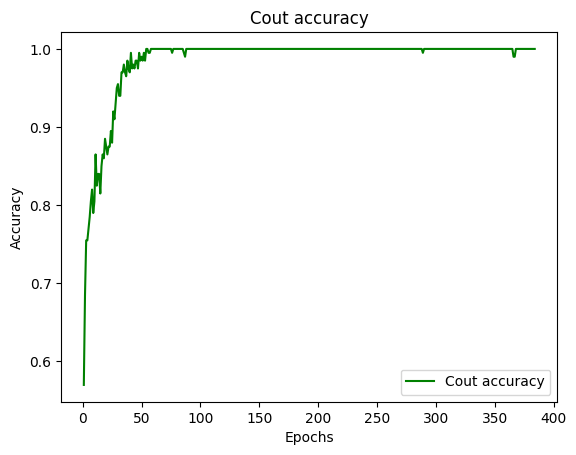

In [25]:
out1_accuracy = history[0].history['output_1_accuracy']


epochs = range(1,history[0].epoch[-1]+2)
plt.plot(epochs, out1_accuracy, 'g', label='Cout accuracy')

plt.title('Cout accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

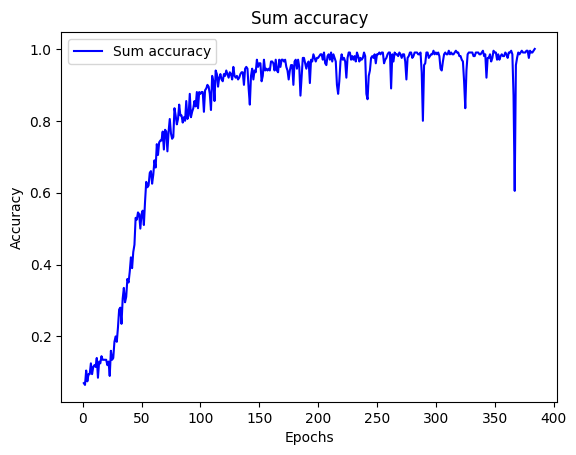

In [26]:
out2_accuracy = history[0].history['output_2_accuracy']
plt.plot(epochs, out2_accuracy, 'b', label='Sum accuracy')
plt.title('Sum accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It is the moment to evaluate the model.

number_equalizer is used for making the number used for testing equals in terms of digit number.

In [59]:
def number_equalizer(A: str, B: str):
    if(len(A) > len(B)):
        B = B.zfill(len(A))
    else:
        A = A.zfill(len(B))
    return A, B

A and B are arbitrary, try whatever number of different lengths you prefere.

The possible advantage of this experiment is that CPU only performs the DNN computation because digit are stored as string.

Overflow in summation is then eliminated by paying in terms of speed computing.

In [75]:
SUM = ""
Cout = 0

A='55998789797999779099999999876559898987878776656375009082580295555'
B='82580299999987877665637509987655709055555789797999779099989898985'

A_n, B_n = number_equalizer(A, B)


for (ai, bi) in zip(A_n[::-1], B_n[::-1]):
    evaluation = model.predict([[int(ai),int(bi),Cout]],verbose = 0)
    SUM = str(np.argmax(evaluation[1][0])) + SUM
    Cout = 1 if evaluation[0][0][0] > 0.98 else 0
if(Cout == 1):
    SUM = f"{Cout}" + SUM
if(Cout == 1) :
    print(f" {A} + \n {B} = \n{SUM}")
else:
    print(f"{A} + \n{B} = \n{SUM}")

 55998789797999779099999999876559898987878776656375009082580295555 + 
 82580299999987877665637509987655709055555789797999779099989898985 = 
138579089797987656765637509864215608043434566454374788182570194540
